# 상관분석
## 공분산

In [13]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np
from hossam import load_data
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

## 그래프 초기화

In [14]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [15]:
origin = load_data('language_math_scores')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab11_/language_math_scores.xlsx
[desc] 어느 학급의 언어영역과 수리영역 점수를 기록한 가상의 데이터 셋

field     type    description
--------  ------  -------------
언어영역  INT     언어영역 점수
수리영역  INT     수리영역 점수

데이터셋 크기: (50, 2)
열 개수: 2
행 개수: 50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   언어영역    50 non-null     int64
 1   수리영역    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,언어영역,수리영역
0,66,66
1,58,70
2,73,74
3,52,58
4,72,79


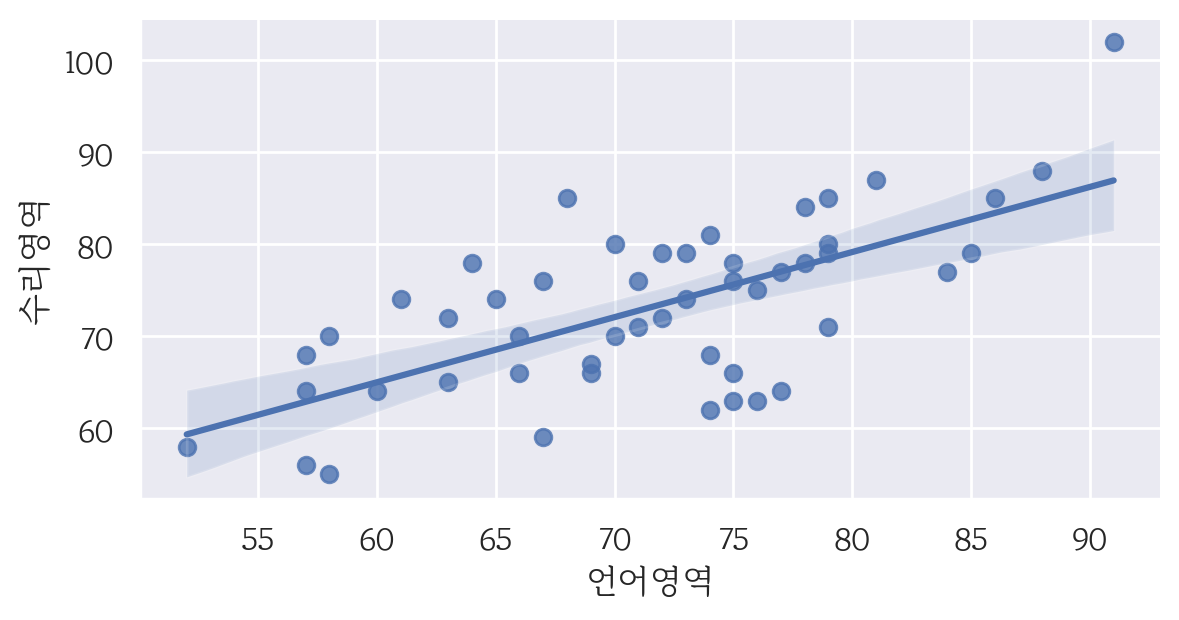

In [16]:
width_px = 1200
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)

# lmplot 그리기
g= sb.lmplot(data=origin, x ='언어영역', y='수리영역') # col, row 선택사항
g.fig.set_figwidth(figsize[0])                                                                            
g.fig.set_dpi(my_dpi)
g.fig.set_figheight(figsize[1])
# 그래프 꾸미기
plt.grid() # 배경 격자 표시/숨김, 조건별 병렬 시각화에서는 사용 안함

# 출력
plt.tight_layout()
plt.show()
plt.close()

## 선형성 통계적 검정



In [17]:
x = origin['수리영역']
y = origin['언어영역']

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
reset = linear_reset(model, power = 2, use_f = True)

# 선형성 적합 여부(True 적합, False = 부적합)
linearity_ok = reset.pvalue > 0.05
print(f'Ramsey RESET Test: {'선형성 적합' if linearity_ok else '선형성 위반'}(p-value: {reset.pvalue:.4f})')

Ramsey RESET Test: 선형성 적합(p-value: 0.7322)


## 공분산

In [18]:
c = np.cov(origin['언어영역'], origin['수리영역'])
c

array([[76.86693878, 54.39020408],
       [54.39020408, 85.57714286]])

# 상관분석 
## 분포 왜도를 통한 이상치 점검

In [19]:
data = origin[['언어영역', '수리영역']]
results = {}

for col in data.columns:
    temp = data[col]. dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # z-score 기반 이상치 탐지(|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3 ))

    # 로그 변환 후 왜도 계산(음수 대비 + 1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1 ) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3 )': outlier_count,
        'log_recommended': need_log
    }

results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 점검 결과
outlier_flag = len((results_df['outliers(|z| > 3 )'] > 0)) > 0
if outlier_flag:
    print('이상치가 발견되어 스피어만 상관계수 사용')
else:
    print('이상치가 발견되지 않아 피어슨 상관계수 사용')

,original_skew,log_skew,outliers(|z| > 3 ),log_recommended
언어영역,-0.102559,-1.735952,0,False
수리영역,0.367414,-1.529107,1,False


이상치가 발견되어 스피어만 상관계수 사용


## 상관분석

In [20]:
pearson_r, pearson_p = pearsonr(origin['언어영역'], origin['수리영역'])  
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(pearson_r, pearson_p, '대립' if pearson_p < 0.05 else '귀무')

'statistic: 0.671, p-value: 0.000, 대립가설 채택'

In [21]:
spearman_r, spearman_p = spearmanr(origin['언어영역'], origin['수리영역'])  
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(spearman_r, spearman_p, '대립' if spearman_p < 0.05 else '귀무')

'statistic: 0.599, p-value: 0.000, 대립가설 채택'

## 가정에 따른 상관계수 선택

In [22]:
# 상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearson_r, pearson_p
    rationale = '선형성 만족 + 왜도/이상치 영향 작음으로 판단'
else:
    chosen = 'spearman'
    corr, pval = spearman_r, spearman_p
    rationale = '비선형(또는 이상치 영향) 가능성 고려'

print('=' * 50)
print(' 상관계수 요약')
print('=' * 50)
print(f"Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.4f}")
print(f"Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.4f}")
print('\n' + '=' * 50)
print(' 최종 선택 결과')
print('=' * 50)
print(f"선택된 방법: {chosen}")
print(f"상관계수: {corr:.3f}")
print(f"p-value: {pval:.4f}")
print(f"선택 근거: {rationale}")
print('=' * 50)

 상관계수 요약
Pearson r: 0.671, p-value: 0.0000
Spearman rho: 0.599, p-value: 0.0000

 최종 선택 결과
선택된 방법: spearman
상관계수: 0.599
p-value: 0.0000
선택 근거: 비선형(또는 이상치 영향) 가능성 고려


## 상관계수 히트맵

In [23]:
corr_matrix = origin[['언어영역', '수리영역']].corr(method = chosen)
corr_matrix

,언어영역,수리영역
언어영역,1.000000,0.599095
수리영역,0.599095,1.000000


NameError: name 'ax' is not defined

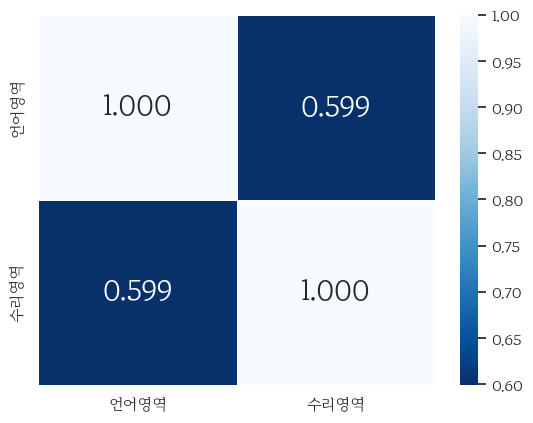

In [24]:
width_px = 1200
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)

# lmplot 그리기
sb.heatmap(data=corr_matrix, annot = True, fmt = '0.3f', linewidth = 0.5,
           cmap = 'Blues_r', annot_kws = {'size': 20}) # col, row 선택사항

# 그래프 꾸미기
plt.grid() # 배경 격자 표시/숨김, 조건별 병렬 시각화에서는 사용 안함
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()


# 출력
plt.tight_layout()
plt.show()
plt.close()

## 인사이트


### 피어슨 r 상관계수를 선택한 경우
- 본 분석에서는 변수1과 변수2 간 상관관계를 검토하였다.
- 데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다.
- 분석 결과, 피어슨 상관계수는 r = {r값}, p = {p값}으로 나타나 두 변수 간 {상관 방향} 관계가 통계적으로 유의함을 확인하였다.

### 스피어만 r 상관계수를 선택한 경우
- 본 분석에서는 변수1과 변수2 간 상관관계를 검토하였다.
- 데이터 점검 과정에서, 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.
- 분석 결과, 스피어만 상관계수는 rho = {rho값}, p = {p값}으로 나타나 두 변수 간 {단조 관계 방향} 관계가 존재함을 확인하였다.

## 연습문제
### 문제 1

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np
from hossam import load_data
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

In [ ]:
origin = load_data('baseball')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab11_/baseball.xlsx
[desc] 야구팀의 홈런수와 타율에 관한 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata
데이터셋 크기: (14, 2)
열 개수: 2
행 개수: 14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   홈런수     14 non-null     int64  
 1   평균타율    14 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 356.0 bytes
None


,홈런수,평균타율
0,174,0.277
1,163,0.276
2,161,0.272
3,230,0.272
4,214,0.269


In [ ]:
x = origin['홈런수']
y = origin['평균타율']

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
reset = linear_reset(model, power = 2, use_f = True)

# 선형성 적합 여부(True 적합, False = 부적합)
linearity_ok = reset.pvalue > 0.05
print(f'Ramsey RESET Test: {'선형성 적합' if linearity_ok else '선형성 위반'}(p-value: {reset.pvalue:.4f})')

Ramsey RESET Test: 선형성 적합(p-value: 0.0910)


In [ ]:
data = origin[['홈런수', '평균타율']]
results = {}

for col in data.columns:
    temp = data[col]. dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # z-score 기반 이상치 탐지(|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3 ))

    # 로그 변환 후 왜도 계산(음수 대비 + 1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1 ) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3 )': outlier_count,
        'log_recommended': need_log
    }

results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 점검 결과
outlier_flag = len(results_df[results_df['outliers(|z| > 3 )'] > 0]) > 0
if outlier_flag:
    print('이상치가 발견되어 스피어만 상관계수 사용')
else:
    print('이상치가 발견되지 않아 피어슨 상관계수 사용')

,original_skew,log_skew,outliers(|z| > 3 ),log_recommended
홈런수,0.512832,-0.97408,0,False
평균타율,0.220918,0.214929,0,False


이상치가 발견되지 않아 피어슨 상관계수 사용


In [ ]:
# 상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearsonr(origin['홈런수'], origin['평균타율'])
    rationale = '선형성 만족 + 왜도/이상치 영향 작음으로 판단'
else:
    chosen = 'spearman'
    corr, pval = spearman_r, spearman_p
    rationale = '비선형(또는 이상치 영향) 가능성 고려'

if chosen == "pearson":
    corr, pval = pearsonr(origin['홈런수'], origin['평균타율'])
    rationale = "두 변수 관계는 선형적이며 이상치 영향이 크지 않음"
    report = (
        f"본 분석에서는 {'xname'}과 {'yname'} 간 상관관계를 검토하였다.\n"
        f"데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 "
        f"피어슨 상관계수를 사용하였다.\n\n"
        f"분석 결과, 피어슨 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타났으며, "
        f"두 변수 간 {'양의 상관' if corr > 0 else '음의 상관'} 관계가 "
        f"통계적으로 유의함을 확인하였다."
    )

else:  # Spearman
    chosen = "spearman"
    corr, pval = spearmanr(origin['홈런수'], origin['평균타율'])
    rationale = "비선형 관계 가능성 또는 이상치 영향 고려"
    report = (
        f"본 분석에서는 {'홈런수'}과 {'평균타율'} 간 상관관계를 평가하였다.\n\n"
        f"데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 "
        f"스피어만 상관계수를 사용하였다.\n\n"
        f"분석 결과, 스피어만 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타났으며, "
        f"두 변수 간 {'양의 단조' if corr > 0 else '음의 단조'} 관계가 존재함을 확인하였다."
    )

# 출력
print(f"선택된 방법: {chosen}")
print(f"상관계수: {corr:.3f}")
print(f"p-value: {pval:.4f}")
print(f"선택 근거: {rationale}")
print("\n======= report =======")
print(report)


선택된 방법: pearson
상관계수: -0.075
p-value: 0.7997
선택 근거: 두 변수 관계는 선형적이며 이상치 영향이 크지 않음

======= report =======
본 분석에서는 xname과 yname 간 상관관계를 검토하였다.
데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다.

분석 결과, 피어슨 상관계수는 r = -0.075, p = 0.800(으)로 나타났으며, 두 변수 간 음의 상관 관계가 통계적으로 유의함을 확인하였다.


In [ ]:
corr_matrix = origin[['홈런수', '평균타율']].corr(method = chosen)
corr_matrix

,홈런수,평균타율
홈런수,1.000000,-0.074695
평균타율,-0.074695,1.000000


NameError: name 'ax' is not defined

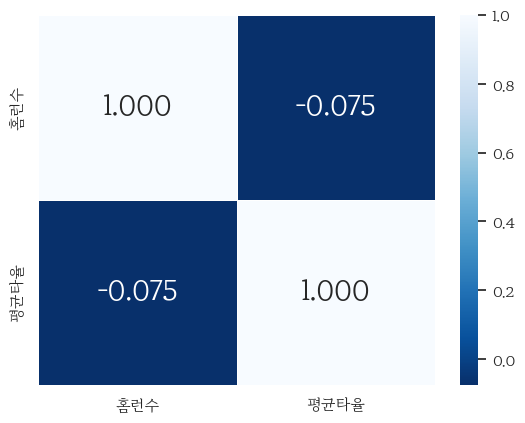

In [ ]:
width_px = 1200
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)

# lmplot 그리기
sb.heatmap(data=corr_matrix, annot = True, fmt = '0.3f', linewidth = 0.5,
           cmap = 'Blues_r', annot_kws = {'size': 20}) # col, row 선택사항

# 그래프 꾸미기
plt.grid() # 배경 격자 표시/숨김, 조건별 병렬 시각화에서는 사용 안함
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()


# 출력
plt.tight_layout()
plt.show()
plt.close()

### 피어슨 r 상관계수를 선택한 경우
- 본 분석에서는 홈런수와 평균타율 간 상관관계를 검토하였다.
- 데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다.
- 분석 결과, 피어슨 상관계수는 r = {r값}, p = {p값}으로 나타나 두 변수 간 {상관 방향} 관계가 통계적으로 유의함을 확인하였다.

### 스피어만 r 상관계수를 선택한 경우
- 본 분석에서는 변수1과 변수2 간 상관관계를 검토하였다.
- 데이터 점검 과정에서, 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.
- 분석 결과, 스피어만 상관계수는 rho = {rho값}, p = {p값}으로 나타나 두 변수 간 {단조 관계 방향} 관계가 존재함을 확인하였다.

## 여러 변수의 상관분석

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np
from hossam import load_data
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr
from itertools import combinations

In [ ]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
origin = load_data('mtcars')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab11_/mtcars.xlsx
[desc] 자동차 32종의 11개 속성에 대한 정보를 담고 있는 데이터 (출처: R 기본 데이터)

필드    타입      설명
------  --------  --------------------------------
name    str       차종 이름 (인덱스)
mpg     str       연료 효율성 (마일 당 갤런)
cyl     category  실린더 수
disp    float     배기량 (cubic inches)
hp      float     마력 (horsepower)
drat    float     후륜축 비율 (rear axle ratio)
wt      float     차량 무게 (1000 파운드)
qsec    float     1/4 마일 달성 시간 (초)
vs      category  엔진 유형 (0: V 엔진, 1: S 엔진)
am      category  변속기 형태 (0: 자동, 1: 수동)
gear    category  전진 기어 수 (전송 기어)
carb    category  기화기 개수 (carburetors)

데이터셋 크기: (32, 11)
열 개수: 11
행 개수: 32
<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Mazda RX4 to Volvo 142E
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     32 non-null     float64
 1   cyl     32 non-null     int64  
 2   disp    32 non-null     float64
 3   hp      32 non-null     int64  
 4   drat    32 non

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
name,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [ ]:
df = origin.filter(['mpg','disp','hp','drat','wt','qsec'])
df

,mpg,disp,hp,drat,wt,qsec
name,,,,,,
Mazda RX4,21.0,160.0,110,3.90,2.620,16.46
Mazda RX4 Wag,21.0,160.0,110,3.90,2.875,17.02
Datsun 710,22.8,108.0,93,3.85,2.320,18.61
Hornet 4 Drive,21.4,258.0,110,3.08,3.215,19.44
Hornet Sportabout,18.7,360.0,175,3.15,3.440,17.02
Valiant,18.1,225.0,105,2.76,3.460,20.22
Duster 360,14.3,360.0,245,3.21,3.570,15.84
Merc 240D,24.4,146.7,62,3.69,3.190,20.00
Merc 230,22.8,140.8,95,3.92,3.150,22.90


## 상관분석 가정 및 시각화

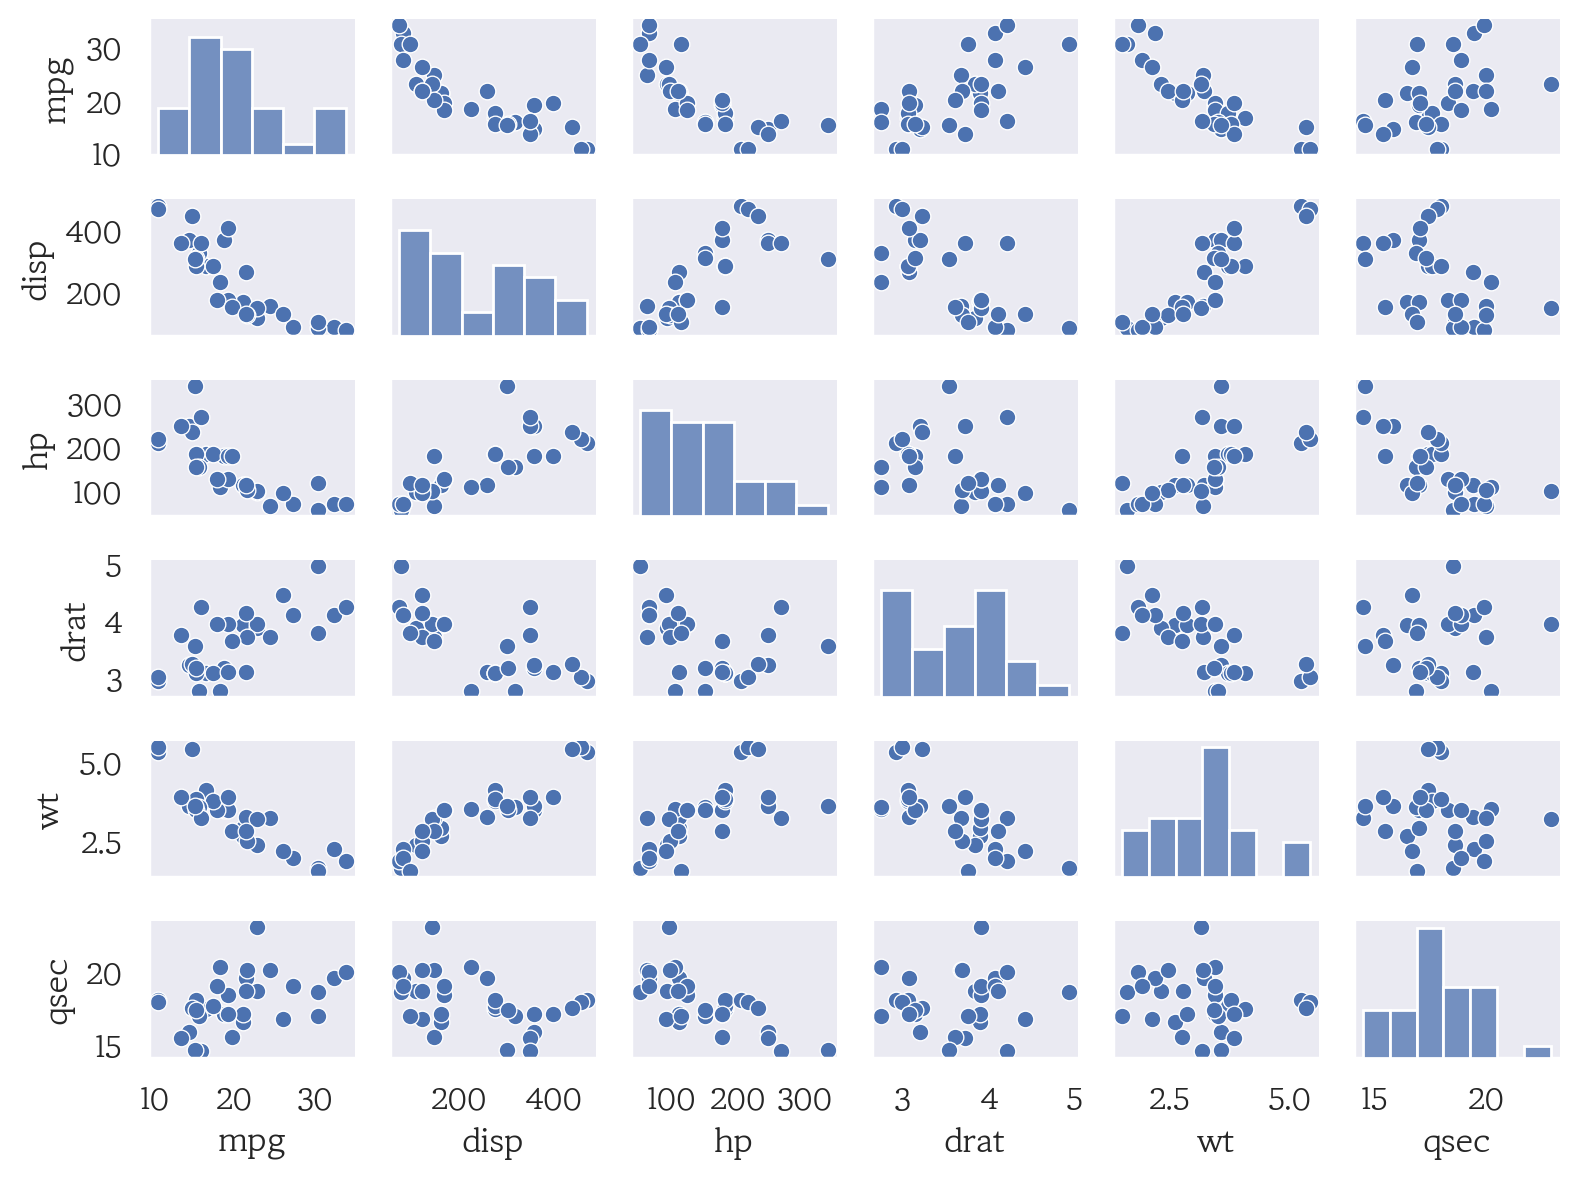

In [ ]:
# 선형성 - 페어플롯

width_px = 1600
height_px = 1200
figsize = (width_px/ my_dpi, height_px / my_dpi)

# pairplot 그리기
# 'corner=True' 파라미터 추가 시 아래쪽 삼각형만 플롯된다
# 'diag_kind' 파라미터에 'hist'값 적용, 'kde': 기본값, 범주별 구분 시 사용
# x_vars, y_vars 파라미터에 원하는 변수를 선택적으로 적용한다, 선택적 변수 적용 시 사용
g= sb.pairplot(df, diag_kind ='hist',) 
               #x_vars = ['⭐', '⭐', '⭐'],
               #y_vars = ['⭐', '⭐'])
# 그룹별로 묶어서 표시할 때 사용
g.fig.set_size_inches(figsize)                                                                          
g.fig.set_dpi(my_dpi)

# 출력
plt.tight_layout()
plt.show()
plt.close()

## 이상치 요약
### 미리 처리해두기

In [ ]:
skew_outlier = {}
for col in df.columns:
    temp = df[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count
    }

skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z|>3)
mpg,0.672377,-0.960191,0.0
disp,0.420233,-1.292987,0.0
hp,0.799407,-1.466775,0.0
drat,0.292780,-0.044575,0.0
wt,0.465916,-0.298323,0.0
qsec,0.406347,-0.770281,0.0


## 변수 쌍별 상관 검정 및 방법 선택
### intertools의 combinations함수 기능 확인

In [ ]:
a = [10, 20, 30]
aa = combinations(a, r=2)

for c in aa:
    print(c)

(10, 20)
(10, 30)
(20, 30)


## 상관분석 수행

In [ ]:
rows = []

for a, b in combinations(df.columns, 2):
    x = df[a]
    y = df[b]

    # 선형성 확인(Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power = 2, use_f = True)
    linearity_ok = reset.pvalue > 0.05

    # 이상치 존재 여부(|z| > 3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z|>3)'] > 0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z|>3)'] > 0
    outlier_flag = a_flag or b_flag
    
    # 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = "pearson"
        corr, pval = pearsonr(x, y)
    else:
        chosen = 'spearman'
        corr, pval = spearmanr(x, y)

    # 유의성 판단 (p <= 0.05)
    significant = pval <= 0.05

    # 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = 'Very strong'
    elif abs_r >= 0.60:
        strength = 'Strong'
    elif abs_r >= 0.40:
        strength = 'Medium'
    elif abs_r >= 0.20:
        strength = 'Weak'
    else:
        strength = 'Very weak'
    
    # 행 추가
    rows.append({
        'var_a': a,
        'var_b': b,
        'linearity': linearity_ok,
        'outlier_flag': outlier_flag,
        'chosen': chosen,
        'corr': corr,
        'pval': pval,
        'significant': significant,
        'strength': strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,mpg,disp,False,False,spearman,-0.908882,6.370336e-13,True,Very strong
1,mpg,hp,True,False,pearson,-0.776168,1.787835e-07,True,Strong
2,mpg,drat,True,False,pearson,0.681172,1.776240e-05,True,Strong
3,mpg,wt,False,False,spearman,-0.886422,1.487595e-11,True,Very strong
4,mpg,qsec,True,False,pearson,0.418684,1.708199e-02,True,Medium
5,disp,hp,True,False,pearson,0.790949,7.142679e-08,True,Strong
6,disp,drat,False,False,spearman,-0.683592,1.613884e-05,True,Strong
7,disp,wt,True,False,pearson,0.887980,1.222320e-11,True,Very strong
8,disp,qsec,True,False,pearson,-0.433698,1.314404e-02,True,Medium
9,hp,drat,False,False,spearman,-0.520125,2.277988e-03,True,Medium


## 결과 시각화
### 상관행렬 생성

In [ ]:
# 등장하는 모든 변수 목록 추출
vars =sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index = vars, columns = vars)

# summary_df 내용 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a,b] = r
    corr_matrix.loc[b,a] = r # 대칭

# 대각선을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)

corr_matrix

,disp,drat,hp,mpg,qsec,wt
disp,1.000000,-0.683592,0.790949,-0.908882,-0.433698,0.887980
drat,-0.683592,1.000000,-0.520125,0.681172,0.091205,-0.712441
hp,0.790949,-0.520125,1.000000,-0.776168,-0.708223,0.774677
mpg,-0.908882,0.681172,-0.776168,1.000000,0.418684,-0.886422
qsec,-0.433698,0.091205,-0.708223,0.418684,1.000000,-0.174716
wt,0.887980,-0.712441,0.774677,-0.886422,-0.174716,1.000000


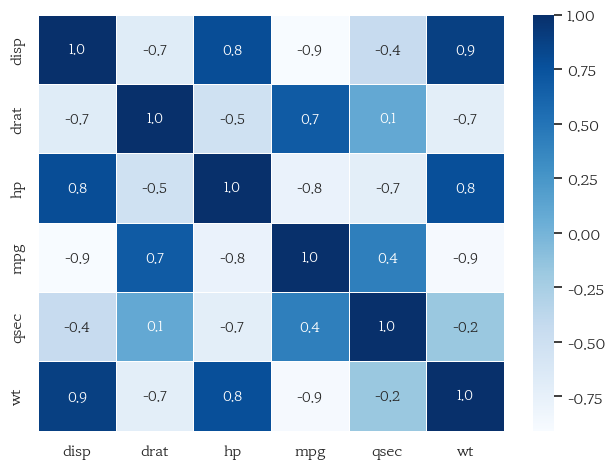

In [ ]:
width_px = 1200
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)

# lmplot 그리기
sb.heatmap(data=corr_matrix, annot = True, fmt = '0.1f', linewidth = 0.5,
           cmap = 'Blues', annot_kws = {'size': 10}) # col, row 선택사항

# 출력
plt.tight_layout()
plt.show()
plt.close()

## 연습문제
### 문제 1

In [29]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np
from hossam import load_data
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr
from itertools import combinations

In [50]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 6
plt.rcParams['axes.unicode_minus'] = False

In [39]:
origin = load_data('penguins')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/penguins.xlsx
[desc] 남극 팔머 군도의 펭귄 3종에 대해 신체 치수와 서식지 정보(출처: https://www.kaggle.com/datasets/larsen0966/penguins)

field              description
-----------------  -------------
species            팽귄 종
island             서식지
bill_length_mm     부리 길이
bill_depth_mm      부리 두께
flipper_length_mm  날개 길이
body_mass_g        몸무게
sex                성별

데이터셋 크기: (334, 7)
열 개수: 7
행 개수: 334
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   bill_length_mm     334 non-null    float64
 3   bill_depth_mm      334 non-null    float64
 4   flipper_length_mm  334 non-null    int64  
 5   body_mass_g        334 non-null    int64  
 6   sex                333 non-null    object 
dtypes: float64(2), int64(2), object(3)
m

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,MALE
1,Adelie,Torgersen,39.5,17.4,186,3800,FEMALE
2,Adelie,Torgersen,40.3,18.0,195,3250,FEMALE
3,Adelie,Torgersen,36.7,19.3,193,3450,FEMALE
4,Adelie,Torgersen,39.3,20.6,190,3650,MALE


In [40]:
df = origin.filter(['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g'])
df

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181,3750
1,39.5,17.4,186,3800
2,40.3,18.0,195,3250
3,36.7,19.3,193,3450
4,39.3,20.6,190,3650
...,...,...,...,...
329,47.2,13.7,214,4925
330,46.8,14.3,215,4850
331,50.4,15.7,222,5750
332,45.2,14.8,212,5200


In [41]:
skew_outlier = {}
for col in df.columns:
    temp = df[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count
    }

skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z|>3)
bill_length_mm,0.050796,-0.765943,0.0
bill_depth_mm,-0.155316,-0.732511,0.0
flipper_length_mm,0.359305,-0.791583,0.0
body_mass_g,0.471045,-2.611903,0.0


In [42]:
rows = []

for a, b in combinations(df.columns, 2):
    x = df[a]
    y = df[b]

    # 선형성 확인(Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power = 2, use_f = True)
    linearity_ok = reset.pvalue > 0.05

    # 이상치 존재 여부(|z| > 3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z|>3)'] > 0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z|>3)'] > 0
    outlier_flag = a_flag or b_flag
    
    # 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = "pearson"
        corr, pval = pearsonr(x, y)
    else:
        chosen = 'spearman'
        corr, pval = spearmanr(x, y)

    # 유의성 판단 (p <= 0.05)
    significant = pval <= 0.05

    # 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = 'Very strong'
    elif abs_r >= 0.60:
        strength = 'Strong'
    elif abs_r >= 0.40:
        strength = 'Medium'
    elif abs_r >= 0.20:
        strength = 'Weak'
    else:
        strength = 'Very weak'
    
    # 행 추가
    rows.append({
        'var_a': a,
        'var_b': b,
        'linearity': linearity_ok,
        'outlier_flag': outlier_flag,
        'chosen': chosen,
        'corr': corr,
        'pval': pval,
        'significant': significant,
        'strength': strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,bill_length_mm,bill_depth_mm,False,False,spearman,-0.216209,6.782928e-05,True,Weak
1,bill_length_mm,flipper_length_mm,False,False,spearman,0.671510,3.901395e-45,True,Strong
2,bill_length_mm,body_mass_g,False,False,spearman,0.579194,2.591284e-31,True,Medium
3,bill_depth_mm,flipper_length_mm,False,False,spearman,-0.518341,2.317525e-24,True,Medium
4,bill_depth_mm,body_mass_g,False,False,spearman,-0.430729,1.609964e-16,True,Medium
5,flipper_length_mm,body_mass_g,False,False,spearman,0.841582,8.031883e-91,True,Very strong


In [43]:
# 등장하는 모든 변수 목록 추출
vars =sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index = vars, columns = vars)

# summary_df 내용 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a,b] = r
    corr_matrix.loc[b,a] = r # 대칭

# 대각선을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)

corr_matrix

,bill_depth_mm,bill_length_mm,body_mass_g,flipper_length_mm
bill_depth_mm,1.000000,-0.216209,-0.430729,-0.518341
bill_length_mm,-0.216209,1.000000,0.579194,0.671510
body_mass_g,-0.430729,0.579194,1.000000,0.841582
flipper_length_mm,-0.518341,0.671510,0.841582,1.000000


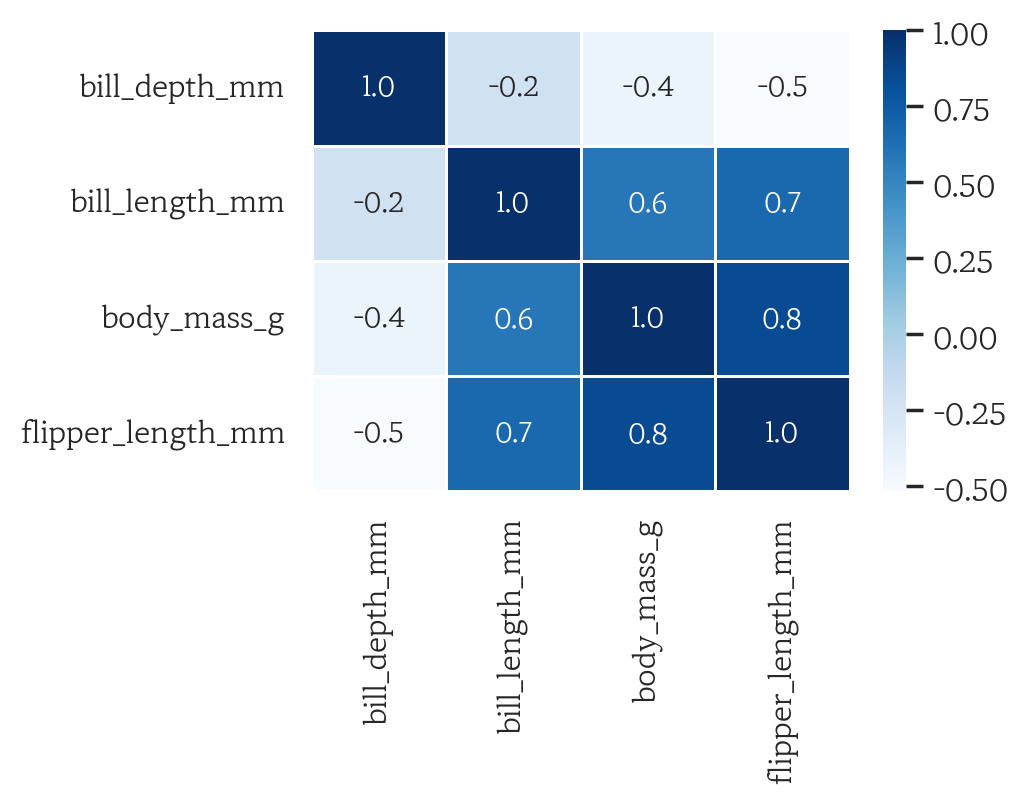

In [51]:
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)
# heatplot 그리기
sb.heatmap(data=corr_matrix, annot = True, fmt = '0.1f', linewidth = 0.5,
           cmap = 'Blues', annot_kws = {'size': 10}) # col, row 선택사항


# 출력
plt.tight_layout()
plt.show()
plt.close()